In [1]:
import pandas as pd

Наши новости

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [4]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [5]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [6]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

stopword_ru

['и',
 'в',
 'во',
 'не',
 'что',
 'он',
 'на',
 'я',
 'с',
 'со',
 'как',
 'а',
 'то',
 'все',
 'она',
 'так',
 'его',
 'но',
 'да',
 'ты',
 'к',
 'у',
 'же',
 'вы',
 'за',
 'бы',
 'по',
 'только',
 'ее',
 'мне',
 'было',
 'вот',
 'от',
 'меня',
 'еще',
 'нет',
 'о',
 'из',
 'ему',
 'теперь',
 'когда',
 'даже',
 'ну',
 'вдруг',
 'ли',
 'если',
 'уже',
 'или',
 'ни',
 'быть',
 'был',
 'него',
 'до',
 'вас',
 'нибудь',
 'опять',
 'уж',
 'вам',
 'ведь',
 'там',
 'потом',
 'себя',
 'ничего',
 'ей',
 'может',
 'они',
 'тут',
 'где',
 'есть',
 'надо',
 'ней',
 'для',
 'мы',
 'тебя',
 'их',
 'чем',
 'была',
 'сам',
 'чтоб',
 'без',
 'будто',
 'чего',
 'раз',
 'тоже',
 'себе',
 'под',
 'будет',
 'ж',
 'тогда',
 'кто',
 'этот',
 'того',
 'потому',
 'этого',
 'какой',
 'совсем',
 'ним',
 'здесь',
 'этом',
 'один',
 'почти',
 'мой',
 'тем',
 'чтобы',
 'нее',
 'сейчас',
 'были',
 'куда',
 'зачем',
 'всех',
 'никогда',
 'можно',
 'при',
 'наконец',
 'два',
 'об',
 'другой',
 'хоть',
 'после',
 'на

In [7]:
morph = pymorphy2.MorphAnalyzer()


In [8]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
stopword_ru += ['nn', 'nnn']
len(stopword_ru)

778

In [9]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
#    text = re.sub(r"-\s\r\n\|-\s\r\n|\r\n", '', text)
    text = re.sub(r"-\s*\r\n|-\s*\n|-\s*\r", '', text)  # переносы
    text = re.sub(r"[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]", ' ', text)
    text = re.sub(r"\r\n\t|\n|\s|\r\t|\\n", ' ', text) # нормализация пробелы 
    text = re.sub(r'[\xad\s]+', ' ', text.strip()) # сокращение пробелов
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [10]:
news['title'][0]

'Заместитель председателяnправительства РФnСергейnИвановnизбран председателем советаnПБК ЦСКАn. Как сообщаетnпресс-службаnармейцев, такое решение было единогласно принято на первом заседании совета клуба. Основной функцией этого органа будет обсуждение текущего состояния, планирование и утверждение стратегии развития клуба на ближайшую перспективу.nnВ состав совета вошли:nГеоргий Полтавченкоn(полномочный представитель президента в Центральном федеральном округе),nАлексей Седовn(генерал-полковник, начальник службы по защите конституционного строя и борьбе с терроризмомnФСБ РФn),nАлександр Новакn(заместитель министра финансов РФ),nВячеслав Полтавцевn(заместитель генерального директора, руководитель блока по взаимодействию с органами власти, социальной и корпоративной политикиnГМК «Норильский никель»n),nЛеонид Исаковичn(генеральный директор ООО «УК «Спортивные проекты»),nОльга Плешаковаn(генеральный директорn«Трансаэро»n),nАлександр Провоторовn, (генеральный директорnОАО «Ростелеком»n), А

In [11]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Possible nested set at position 39
  from ipykernel import kernelapp as app


Wall time: 10.7 s


In [12]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 2min 59s


In [13]:
news['title'][0]

['заместитель',
 'председатель',
 'правительство',
 'рф',
 'сергей',
 'иванов',
 'избрать',
 'председатель',
 'совет',
 'пбк',
 'цска',
 'сообщать',
 'пресс',
 'служба',
 'армеец',
 'решение',
 'единогласно',
 'принять',
 'первый',
 'заседание',
 'совет',
 'клуб',
 'основной',
 'функция',
 'это',
 'орган',
 'обсуждение',
 'текущий',
 'состояние',
 'планирование',
 'утверждение',
 'стратегия',
 'развитие',
 'клуб',
 'близкий',
 'перспектива',
 'состав',
 'совет',
 'войти',
 'георгий',
 'полтавченко',
 'полномочный',
 'представитель',
 'президент',
 'центральный',
 'федеральный',
 'округ',
 'алексей',
 'седов',
 'генерал',
 'полковник',
 'начальник',
 'служба',
 'защита',
 'конституционный',
 'строй',
 'борьба',
 'терроризм',
 'фсб',
 'рф',
 'александр',
 'новак',
 'заместитель',
 'министр',
 'финансы',
 'рф',
 'вячеслав',
 'полтавец',
 'заместитель',
 'генеральный',
 'директор',
 'руководитель',
 'блок',
 'взаимодействие',
 'орган',
 'власть',
 'социальный',
 'корпоративный',
 'политика

А теперь в 3 строчки обучим нашу модель

In [14]:
texts = [t for t in news['title'].values] #[3:]


In [15]:
# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [16]:
common_dictionary[0]

'александр'

In [17]:
[(common_dictionary[i], f) for (i, f) in common_corpus[0]][0:10]

[('александр', 2),
 ('алексей', 1),
 ('андрей', 2),
 ('армеец', 1),
 ('банк', 1),
 ('баскетбол', 1),
 ('близкий', 1),
 ('блок', 1),
 ('борьба', 1),
 ('ватутин', 1)]

Запускаем обучение

In [18]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary, random_state=42)#, passes=10)

Wall time: 34.2 s


In [19]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)


In [20]:
# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [21]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_texts

[['заместитель',
  'председатель',
  'правительство',
  'рф',
  'сергей',
  'иванов',
  'избрать',
  'председатель',
  'совет',
  'пбк',
  'цска',
  'сообщать',
  'пресс',
  'служба',
  'армеец',
  'решение',
  'единогласно',
  'принять',
  'первый',
  'заседание',
  'совет',
  'клуб',
  'основной',
  'функция',
  'это',
  'орган',
  'обсуждение',
  'текущий',
  'состояние',
  'планирование',
  'утверждение',
  'стратегия',
  'развитие',
  'клуб',
  'близкий',
  'перспектива',
  'состав',
  'совет',
  'войти',
  'георгий',
  'полтавченко',
  'полномочный',
  'представитель',
  'президент',
  'центральный',
  'федеральный',
  'округ',
  'алексей',
  'седов',
  'генерал',
  'полковник',
  'начальник',
  'служба',
  'защита',
  'конституционный',
  'строй',
  'борьба',
  'терроризм',
  'фсб',
  'рф',
  'александр',
  'новак',
  'заместитель',
  'министр',
  'финансы',
  'рф',
  'вячеслав',
  'полтавец',
  'заместитель',
  'генеральный',
  'директор',
  'руководитель',
  'блок',
  'взаимод

In [22]:
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]
[(common_dictionary[i], f) for (i, f) in other_corpus[0]][0:10]

[('александр', 2),
 ('алексей', 1),
 ('андрей', 2),
 ('армеец', 1),
 ('банк', 1),
 ('баскетбол', 1),
 ('близкий', 1),
 ('блок', 1),
 ('борьба', 1),
 ('ватутин', 1)]

In [23]:
unseen_doc = other_corpus[0]
lda[unseen_doc] 

[(6, 0.0122140795),
 (11, 0.029155431),
 (14, 0.030824719),
 (19, 0.6027989),
 (21, 0.30806276)]

In [24]:
x=lda.show_topics(num_topics=25, num_words=10,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: военный украина год гражданин украинский российский наука россия земля взрыв
topic_1: статья египет порт океан планета адмирал следствие теоретически нейтральный смит
topic_2: погибнуть человек который памятник год город знаменитый узнать бой параметр
topic_3: джордж сопротивляться джеймс переместиться эммануэль индиана тайлера мэн форсайт коваленко
topic_4: регион область температура рак эксперимент это россия проверка министр развитие
topic_5: это всё который мочь свой земля весь время день человек
topic_6: год млн составить стоимость доллар цена общий рынок сумма рейтинг
topic_7: это год который россия мочь работа российский весь новый свой
topic_8: год это который компания млрд страна экономика цена первый стать
topic_9: журнал японский япония устойчивый ми антонов акула недостоверный модный корея
topic_10: это журнал который свет общество человек девочка всё сократиться больной
topic_11: напомнить характерный свидетель звонок пищевой ведение явиться инвестировать точнее с

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [25]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
#    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))
    not_null_topics = dict(lda_tuple)

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [26]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.012208,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.602529,0.0,0.308382,0.0,0.000000,0.000000
1,4896,0.421206,0.0,0.370748,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.186023
2,4897,0.000000,0.0,0.000000,0.0,0.0,0.701243,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.277822,0.000000,0.0,0.000000,0.0,0.000000,0.000000
3,4898,0.229552,0.0,0.197195,0.0,0.0,0.481303,0.054032,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.023866,0.000000
4,4899,0.404821,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.252259,0.0,0.222548,0.0,0.000000,0.000000


In [27]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [28]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [29]:
doc_dict[293622]

array([0.        , 0.        , 0.06376936, 0.        , 0.03589928,
       0.        , 0.        , 0.07039528, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.0642123 , 0.21934968,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.16557053, 0.        , 0.05162129, 0.11968736, 0.19992943])

In [30]:
from math import log
doc_weight_dict = {}
max_weight = 0
for (doc_id, topics) in doc_dict.items():
    weight = doc_weight_dict[doc_id] = log(len(topics)/np.count_nonzero(topics))
    if max_weight < weight:
        max_weight = weight
max_weight

3.2188758248682006

In [31]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list, aggregate = None, use_doc_weights = False):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] * (doc_weight_dict[doc_id] if use_doc_weights else 1) for doc_id in user_articles_list])
    if aggregate == None:
        aggregate = lambda x: np.mean(x, 0)
    user_vector = aggregate(user_vector)
    return user_vector

In [32]:
get_user_embedding(user_articles_list)

array([0.09362507, 0.        , 0.        , 0.00174119, 0.0358265 ,
       0.02157627, 0.00671575, 0.32721255, 0.09100275, 0.        ,
       0.        , 0.        , 0.00267605, 0.0087274 , 0.        ,
       0.03638969, 0.00999521, 0.00315013, 0.        , 0.04405884,
       0.1165951 , 0.08318981, 0.07198617, 0.0078645 , 0.02690041])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [33]:
def get_user_embeddings(users, aggregate, use_doc_weights = False):
    user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, aggregate, use_doc_weights), 1)])
    user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
    user_embeddings['uid'] = users['uid'].values
    user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
    return user_embeddings


In [34]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt

%matplotlib inline



def train_and_predict(users, target, aggregate, use_doc_weights = False):
    user_embeddings = get_user_embeddings(users, aggregate, use_doc_weights)
    X = pd.merge(user_embeddings, target, 'left')
#    display(X.head(3))
    X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    return (y_test, logreg.predict_proba(X_test)[:, 1])


import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def show_metrics(y_test, preds):
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    metrics = (thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test, preds))
    metrics += ('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, ROC-AUC-Score=%.3f' % metrics,)
    print(metrics[-1])
    
    font = {'size' : 15}

    plt.rc('font', **font)

    cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
    plt.savefig("conf_matrix.png")
    plt.show()
    return metrics
    
all_metrics = []

Best Threshold=0.242318, F-Score=0.640, Precision=0.584, Recall=0.706, ROC-AUC-Score=0.935
Confusion matrix, without normalization
[[1632  123]
 [  73  172]]


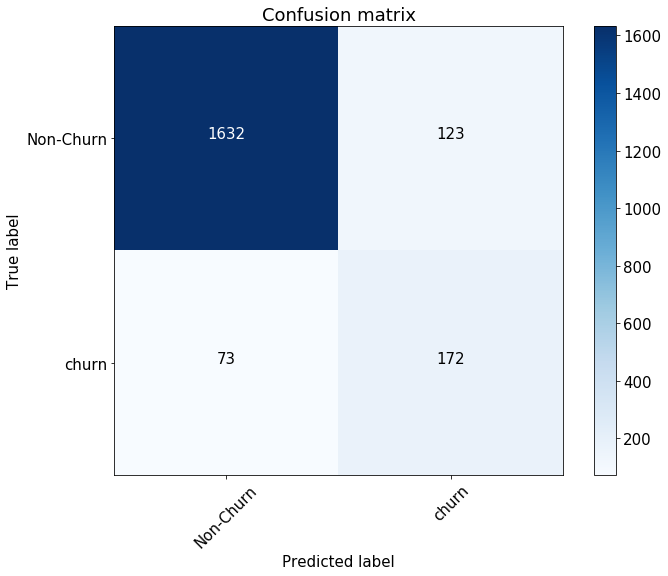

In [36]:
#наши прогнозы для тестовой выборки - Среднее
y_test, preds = train_and_predict(users, target, lambda x: np.mean(x, 0))
all_metrics.append(("Среднее",) + show_metrics(y_test, preds))

Best Threshold=0.236252, F-Score=0.722, Precision=0.661, Recall=0.796, ROC-AUC-Score=0.961
Confusion matrix, without normalization
[[1655  100]
 [  51  194]]


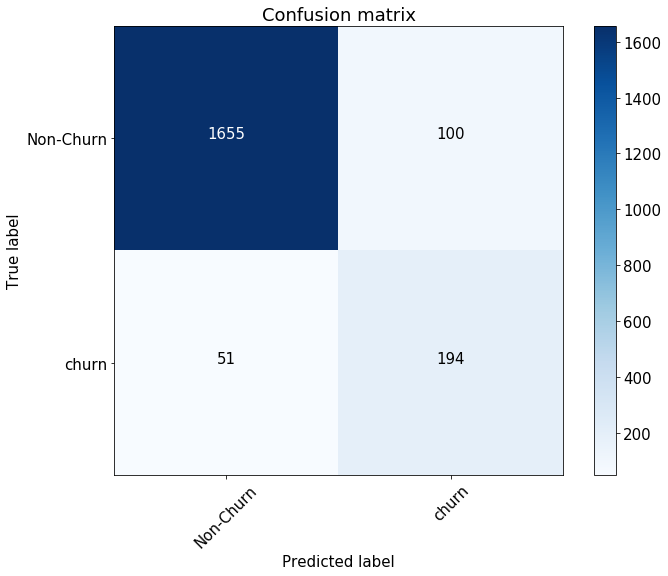

In [37]:
#наши прогнозы для тестовой выборки - Медиана
y_test, preds = train_and_predict(users, target, lambda x: np.median(x, 0))
all_metrics.append(("Медиана",) + show_metrics(y_test, preds))

Best Threshold=0.319546, F-Score=0.781, Precision=0.738, Recall=0.829, ROC-AUC-Score=0.966
Confusion matrix, without normalization
[[1683   72]
 [  43  202]]


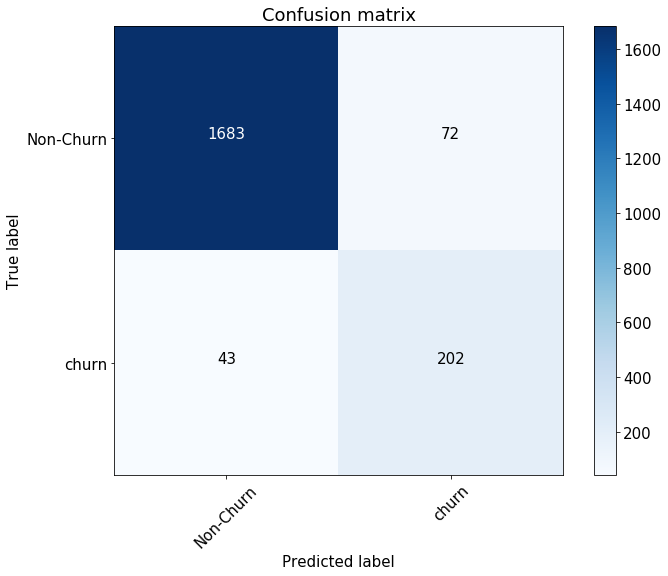

In [38]:
#наши прогнозы для тестовой выборки - Максимум
y_test, preds = train_and_predict(users, target, lambda x: np.max(x, 0))
all_metrics.append(("Максимум",) + show_metrics(y_test, preds))

Best Threshold=0.429683, F-Score=0.897, Precision=0.905, Recall=0.890, ROC-AUC-Score=0.989
Confusion matrix, without normalization
[[1732   23]
 [  28  217]]


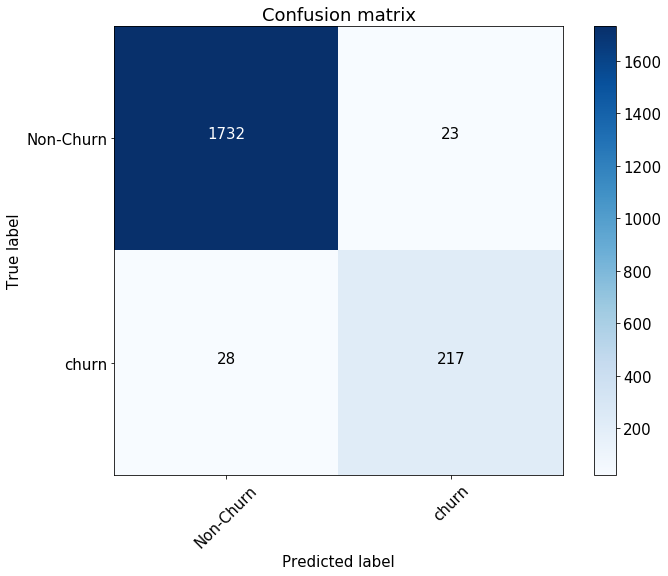

In [39]:
#наши прогнозы для тестовой выборки - Максимум, с idf-подобным весом документов (документы с меньшим числом тем имеют больший вес)
y_test, preds = train_and_predict(users, target, lambda x: np.max(x, 0), True)
all_metrics.append(("Максимум",) + show_metrics(y_test, preds))

In [40]:
for m in all_metrics:
    print(f'{m[0]}: {m[-1]}')

Среднее: Best Threshold=0.242318, F-Score=0.640, Precision=0.584, Recall=0.706, ROC-AUC-Score=0.935
Медиана: Best Threshold=0.236252, F-Score=0.722, Precision=0.661, Recall=0.796, ROC-AUC-Score=0.961
Максимум: Best Threshold=0.319546, F-Score=0.781, Precision=0.738, Recall=0.829, ROC-AUC-Score=0.966
Максимум: Best Threshold=0.429683, F-Score=0.897, Precision=0.905, Recall=0.890, ROC-AUC-Score=0.989


### Выводы ###
* Наилучший результат (без idf-поднобных весов) был получен с аггрегированием по max, вероятно потому что выделяет интересующие пользователя темы уже за счет прочтения какой-нибудь статьи с наибольшей ассоциацией с темой. Использование среднего, наоборот, уменьшает связь пользователя с темой за счет чтения статей по другим темам, что кажется неправильным.  
* Выбор тем и итоговое качество сильно зависело от случайной инициализации, зафиксировала для предсказуемости с помощью random_state. Но были и лучше результаты, в том числе с медианой, повторить не могу
* Использование idf-подобного веса документов (документы с меньшим числом тем получают больший вес) привело к существенному улучшению качества.

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

#### Библиотеки, которые нужно установить:

1. gensim
2. razdel
3. pymorphy2
4. nltk